In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm

To create these plots I first need to prepare the input files for each FEP calculation. We only need the input .pdb containing the ligands and the input Q topology files. The following commands will generate all files needed for this notebook's analysis.

First, make sure your current working directory is on the [perturbations](../perturbations/) directory, then run the following commands:

```shell
cd bace && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd cdk2 && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42  && rm */*/inputfiles/*.inp && cd ../
cd jnk1 && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd mcl1 && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd p38 && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd ptp1b && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd thrombin && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd tyk2 && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd cdk8ManualMapping && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd cmet && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest heavyatom_ls -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd eg5 && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd hif2a && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd shp2 && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd syk && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd pfkfb3 && micromamba run -n qligfep_new setupFEP -FF AMBER14sb_plus_cofactor -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
cd tnks2 && micromamba run -n qligfep_new setupFEP -FF AMBER14sb -c SNELLIUS -r 25 -b auto --start 0.5 -R 10 -S sigmoidal -ts 2fs -clean dcd inp -j mapping.json -log info -rest kartograf -rs 42 && rm */*/inputfiles/*.inp && cd ../
```

In [2]:
all_targets = [
    "bace",
    "cdk2",
    "jnk1",
    "mcl1",
    "p38",
    "ptp1b",
    "thrombin",
    "tyk2",
    "cdk8ManualMapping",
    "cmet",
    "eg5",
    "hif2a",
    "shp2",
    "syk",
    "pfkfb3",
    "tnks2",
]

total_atom_pattern = re.compile(r"^\s*(\d+)\s+(\d+)\s+= Total no\. of atoms, no\. of solute atoms")
exclu_atom_pattern = re.compile(
    r"^\s*(\d+)\s+(\d+)\s=\s+No\. of excluded atoms \(incl\. water\)\, no\. of excluded waters"
)

files = sorted(Path().glob("../perturbations/*/*/*/inputfiles/dualtop.top"))
alldata = []

for idx, file_path in tqdm(enumerate(files), total=len(files)):

    if file_path.parents[3].name not in all_targets:
        continue

    n_atoms, n_solute = None, None
    total_exclu_n_atoms, exclu_n_water_atoms = None, None

    target = file_path.parents[3].name
    if target == "cdk8ManualMapping":
        target = "cdk8"
    edge_name = file_path.parents[1].name.replace("FEP_", "")
    system = file_path.parents[2].name.split(".")[1]

    for line in file_path.open():
        total_match = total_atom_pattern.match(line)
        exclu_match = exclu_atom_pattern.match(line)
        if total_match:
            total_n_atoms = int(total_match.group(1))
            total_n_solute = int(total_match.group(2))
        if exclu_match:
            total_exclu_n_atoms = int(exclu_match.group(1))
            exclu_n_water_atoms = int(exclu_match.group(2))
            break  # Stop reading after finding the match

    alldata.append(
        [target, edge_name, system, total_n_atoms, total_n_solute, total_exclu_n_atoms, exclu_n_water_atoms]
    )

  0%|          | 0/1320 [00:00<?, ?it/s]

In [3]:
df = pd.DataFrame(
    alldata,
    columns=[
        "target",
        "edge_name",
        "system",
        "total_n_atoms",
        "total_n_solute",
        "total_exclu_n_atoms",
        "exclu_n_water_atoms",
    ],
).assign(final_n_atoms=lambda x: x.total_n_atoms - x.total_exclu_n_atoms)

print("Mean in-sphere atom counts by perturbation leg:")
print(df.groupby("system")["final_n_atoms"].mean())
print()
print("Mean total atom counts by protein target:")
print(df.query("system == 'protein'").groupby("target")["total_n_atoms"].mean())

Mean in-sphere atom counts by perturbation leg:
system
protein    6069.081818
water      6359.504545
Name: final_n_atoms, dtype: float64

Mean total atom counts by protein target:
target
bace         8228.551020
cdk2        12042.227273
cdk8         8362.589286
cmet         7445.000000
eg5          8485.243902
hif2a        5971.389831
jnk1         8844.333333
mcl1         6294.177419
p38          8349.283019
pfkfb3       9579.888889
ptp1b        7886.636364
shp2        10384.945946
syk          7445.015873
thrombin     7817.785714
tnks2        6438.151515
tyk2         7642.272727
Name: total_n_atoms, dtype: float64


/tmp/ipykernel_2965796/2077221094.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_2965796/2077221094.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


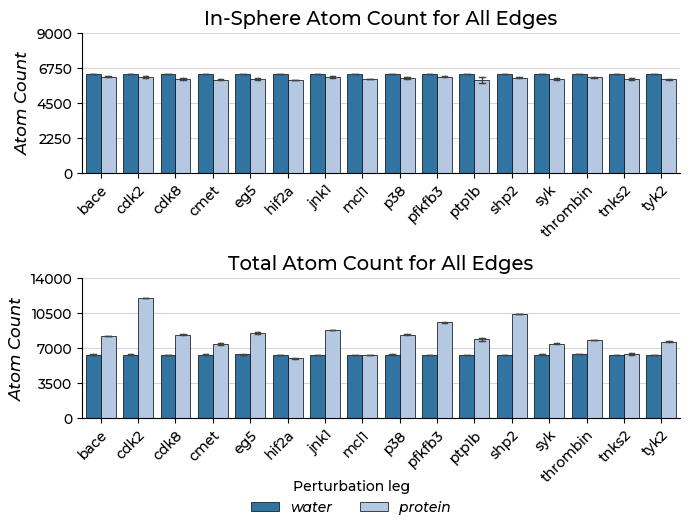

In [4]:
from pyfonts import load_google_font

tick_font = load_google_font("Montserrat", weight=500)
label_font = load_google_font("Montserrat", weight=500, italic=True)
title_font = load_google_font("Montserrat", weight=500)


def set_font_properties(ax, tick_font=tick_font, label_font=label_font, title_font=title_font):
    ax.set_xlabel(ax.get_xlabel(), fontproperties=label_font, size=12)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=label_font, size=12)
    ax.set_title(ax.get_title(), fontproperties=title_font, size=14)
    for label in ax.get_xticklabels():
        label.set_fontproperties(tick_font)
        label.set_fontsize(10)
    for label in ax.get_yticklabels():
        label.set_fontproperties(tick_font)
        label.set_fontsize(10)
    legend = ax.get_legend()
    if legend:
        # Update the font properties of the legend texts
        for text in legend.get_texts():
            text.set_fontproperties(label_font)
        # Optionally, update the font of the legend title if it exists
        if legend.get_title():
            legend.get_title().set_fontproperties(title_font)


palette = "tab20"
fig, axs = plt.subplots(nrows=2, figsize=(7, 5.6))

cols = ["final_n_atoms", "total_n_atoms"]
titles = ["In-Sphere Atom Count for All Edges", "Total Atom Count for All Edges"]

for ax, col, title in zip(axs.flatten(), cols, titles):
    barplot = sns.barplot(
        df,
        hue="system",
        x="target",
        y=col,
        ax=ax,
        palette=palette,
        edgecolor="black",
        linewidth=0.5,
        capsize=0.3,
        err_kws={"linewidth": 1},
        errorbar="sd",
    )

    ax.set_xticklabels(
        barplot.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor",
        fontsize=9,
    )

    sns.despine(ax=ax, top=True, right=True)
    ax.set_title(title)

    if col == cols[0]:
        ax.legend().set_visible(False)
        ax.set_ylim(0, 9000)
        ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    else:
        ax.set_ylim(0, 14000)
        ax.yaxis.set_major_locator(ticker.LinearLocator(5))
        ax.legend(
            title="Perturbation leg",
            loc="upper center",
            bbox_to_anchor=(0.45, -0.35),
            frameon=False,
            shadow=True,
            ncol=2,
        )

    ax.set_ylabel("Atom Count")
    ax.set_xlabel("")
    ax.grid(axis="y", alpha=0.5)
    ax.set_axisbelow(True)

    set_font_properties(ax)

fig.tight_layout()
fig.savefig("../figures/system_sizes.svg", bbox_inches="tight")
fig.savefig("../figures/system_sizes.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()

# Job runtimes

In [5]:
all_targets = [
    "bace",
    "cdk2",
    "jnk1",
    "mcl1",
    "p38",
    "ptp1b",
    "thrombin",
    "tyk2",
    "cdk8ManualMapping",
    "cmet",
    "eg5",
    "hif2a",
    "shp2",
    "syk",
    "pfkfb3",
    "tnks2",
]

all_run_data = []

for target in all_targets:
    parquet_path = Path(f"../results/{target}/{target.replace('ManualMapping', '')}_run_data.parquet")
    if parquet_path.with_suffix(".csv").exists():
        run_data = pd.read_csv(parquet_path.with_suffix(".csv")).to_parquet(parquet_path)
    run_data = pd.read_parquet(parquet_path).assign(target=target)
    all_run_data.append(run_data)

all_run_data = (
    pd.concat(all_run_data, ignore_index=True)
    .query("target != 'cdk8'")
    .assign(target=lambda x: x.target.replace({"cdk8ManualMapping": "cdk8"}))
)
print("Total number of FEP runs:", all_run_data.shape[0])
# note: the number is odd because there might have been runs where the slurm job failed submission,
# thereby disrupting the expected run count.

Total number of FEP runs: 13200


In [6]:
print(
    (
        pd.crosstab(
            all_run_data["target"],
            all_run_data["comment"].replace({"CANCELLED": "OTHER", "TIMEOUT": "OTHER"}),
            normalize="index",
        )
        * 100
    )
    .apply(pd.Series.round, decimals=2)[["SUCCESS", "CRASHED", "OTHER"]]
    .apply(lambda x: x.astype(str) + "%")
    .to_markdown()
)

| target   | SUCCESS   | CRASHED   | OTHER   |
|:---------|:----------|:----------|:--------|
| bace     | 100.0%    | 0.0%      | 0.0%    |
| cdk2     | 100.0%    | 0.0%      | 0.0%    |
| cdk8     | 100.0%    | 0.0%      | 0.0%    |
| cmet     | 100.0%    | 0.0%      | 0.0%    |
| eg5      | 97.56%    | 2.44%     | 0.0%    |
| hif2a    | 100.0%    | 0.0%      | 0.0%    |
| jnk1     | 100.0%    | 0.0%      | 0.0%    |
| mcl1     | 96.77%    | 3.23%     | 0.0%    |
| p38      | 98.11%    | 1.89%     | 0.0%    |
| pfkfb3   | 92.59%    | 7.41%     | 0.0%    |
| ptp1b    | 100.0%    | 0.0%      | 0.0%    |
| shp2     | 100.0%    | 0.0%      | 0.0%    |
| syk      | 96.11%    | 3.81%     | 0.08%   |
| thrombin | 99.64%    | 0.0%      | 0.36%   |
| tnks2    | 100.0%    | 0.0%      | 0.0%    |
| tyk2     | 100.0%    | 0.0%      | 0.0%    |


/tmp/ipykernel_2965796/2812417678.py:122: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(


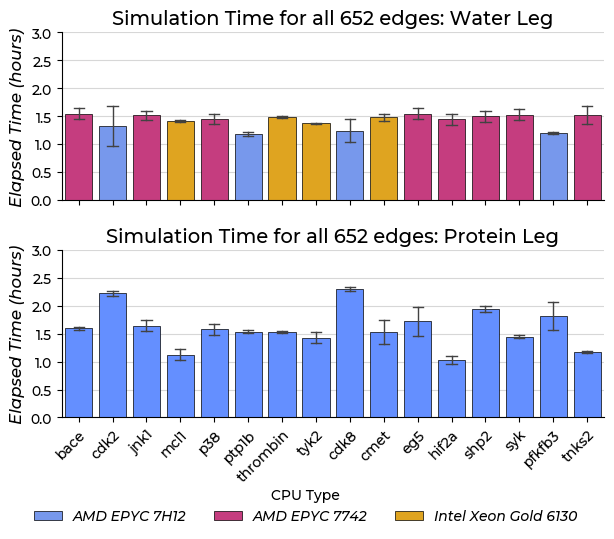

In [7]:
import matplotlib.colors as mcolors

colors = [
    "#648FFF",
    "#DC267F",
    "#FFB000",
]

rgb_colors = [mcolors.to_rgba(c) for c in colors]


def time_to_unit(time_str: str, unit: str = "seconds") -> float:
    hours = minutes = seconds = 0
    if "h" in time_str:
        hours = int(time_str.split("h")[0])
        time_str = time_str.split("h", 1)[1]
    if "m" in time_str:
        minutes = int(time_str.split("m")[0].split(":")[-1])
        time_str = time_str.split("m", 1)[1]
    if "s" in time_str:
        seconds = int(time_str.split("s")[0].split(":")[-1])
    total_seconds = hours * 3600 + minutes * 60 + seconds
    if unit.lower() == "seconds":
        return total_seconds
    elif unit.lower() == "minutes":
        return total_seconds / 60
    elif unit.lower() == "hours":
        return total_seconds / 3600
    else:
        raise ValueError("Invalid unit. Choose 'seconds', 'minutes', or 'hours'.")


targs = [t if t != "cdk8ManualMapping" else t.replace("cdk8ManualMapping", "cdk8") for t in all_targets]
targs_in_dardel = ["bace", "eg5", "hif2a", "jnk1", "p38", "shp2", "syk", "tnks2"]
targs_in_tetralith = ["thrombin", "tyk2", "mcl1", "cmet"]
cpu_mapping = {"dardel": "AMD EPYC 7742", "tetralith": "Intel Xeon Gold 6130", "snellius": "AMD EPYC 7H12"}
color_mapping = {
    "snellius": colors[0],
    "dardel": colors[1],
    "tetralith": colors[2],
}


def where_it_ran(row, dardel=targs_in_dardel, tetra=targs_in_tetralith):
    target = row["target"]
    system = row["system"]
    if system == "2.protein":
        return "snellius"
    else:
        if target in dardel:
            return "dardel"
        elif target in tetra:
            return "tetralith"
        else:
            return "snellius"


transformed = (
    all_run_data.assign(
        elapsed=all_run_data["runtime"].fillna("0h0m0s").apply(time_to_unit, unit="hours"),
    )
    .assign(system=all_run_data["system"].replace({"1.water": "water", "2.protein": "protein"}))
    .query("comment == 'SUCCESS'")
    .assign(where_it_ran=all_run_data.apply(where_it_ran, axis=1))
)

# --- Seaborn plotting solution ---
fig, axs = plt.subplots(nrows=2, figsize=(7, 5), sharex=True)

for ax, system in zip(axs.flatten(), ["water", "protein"]):
    # Filter the data for the current system
    system_data = transformed.query("system == @system")

    # Create the boxplot using seaborn
    sns.barplot(
        data=system_data,
        x="target",
        y="elapsed",
        hue="where_it_ran",
        errorbar="sd",
        order=targs,  # Ensure the order of targets is consistent
        hue_order=color_mapping.keys(),  # Ensure consistent hue order
        palette=color_mapping,
        edgecolor="black",
        linewidth=0.5,
        capsize=0.3,
        err_kws={"linewidth": 1},
        ax=ax,
    )

    ax.set_title(f"Simulation Time for all {all_run_data.FEP.nunique()} edges: {system.capitalize()} Leg")
    ax.set_ylabel("Elapsed Time (hours)")
    ax.set_xlabel("")  # Hide x-label for the top plot
    ax.grid(axis="y", alpha=0.5)
    ax.set_axisbelow(True)

    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()
    # Replace machine names with CPU names for the legend labels
    legend_labels = [cpu_mapping[label] for label in labels]
    sns.despine(ax=ax, top=True, right=True)
    if system == "water":
        ax.legend().set_visible(False)
    else:
        ax.legend(
            handles,
            legend_labels,
            title="CPU Type",
            loc="upper center",
            bbox_to_anchor=(0.45, -0.35),
            frameon=False,
            shadow=True,
            ncol=5,
        )
    # ax.legend(handles, legend_labels, title="CPU Type", bbox_to_anchor=(1.01, 1), loc="upper left")

# Set the colors for axs[1] to all being the same
for patch in axs[1].patches:
    patch.set_facecolor(color_mapping["snellius"])

# Set rotated x-tick labels only for the bottom plot
axs[1].set_xticklabels(
    targs,
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
axs[1].set_xlabel("")
axs[1].set_ylim(0, 3)
axs[0].set_ylim(0, 3)

set_font_properties(axs[0])
set_font_properties(axs[1])

plt.subplots_adjust(hspace=0.3)

fig.savefig("../figures/simulation-time-per-target.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("../figures/simulation-time-per-target.svg", bbox_inches="tight", facecolor="white")

In [8]:
transformed.assign(cpu=lambda x: x.where_it_ran.map(cpu_mapping)).value_counts("cpu") / 12990

cpu
AMD EPYC 7H12           0.625096
AMD EPYC 7742           0.274134
Intel Xeon Gold 6130    0.100770
Name: count, dtype: float64

In [9]:
transformed.assign(cpu=lambda x: x.where_it_ran.map(cpu_mapping)).value_counts(["target", "system", "cpu"])

target    system   cpu                 
syk       protein  AMD EPYC 7H12           620
mcl1      water    Intel Xeon Gold 6130    600
          protein  AMD EPYC 7H12           600
syk       water    AMD EPYC 7742           591
hif2a     protein  AMD EPYC 7H12           590
          water    AMD EPYC 7742           590
cdk8      water    AMD EPYC 7H12           560
          protein  AMD EPYC 7H12           560
p38       water    AMD EPYC 7742           520
          protein  AMD EPYC 7H12           520
pfkfb3    water    AMD EPYC 7H12           520
bace      protein  AMD EPYC 7H12           490
          water    AMD EPYC 7742           490
pfkfb3    protein  AMD EPYC 7H12           480
eg5       protein  AMD EPYC 7H12           400
          water    AMD EPYC 7742           400
shp2      water    AMD EPYC 7742           370
          protein  AMD EPYC 7H12           370
cmet      protein  AMD EPYC 7H12           350
          water    Intel Xeon Gold 6130    350
ptp1b     protein  A

/tmp/ipykernel_2965796/1744007771.py:185: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(


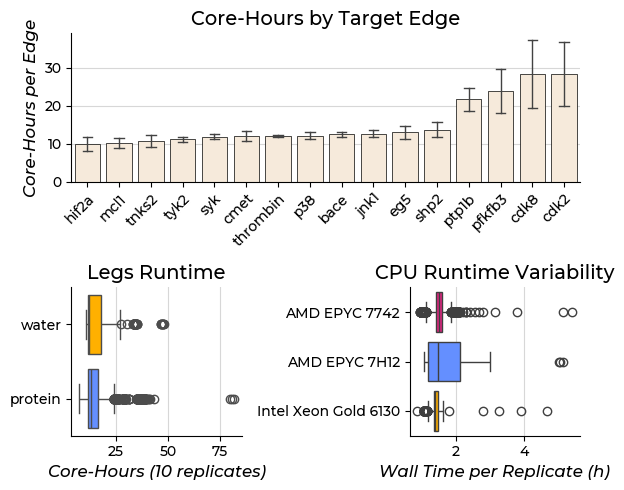

In [10]:
# Define helper functions
def time_to_unit(time_str: str, unit: str = "seconds") -> float:
    """Convert time string to specified unit"""
    hours = minutes = seconds = 0
    if pd.isna(time_str) or time_str == "":
        return 0

    time_str = str(time_str)
    if "h" in time_str:
        hours = int(time_str.split("h")[0])
        time_str = time_str.split("h", 1)[1]
    if "m" in time_str:
        minutes = int(time_str.split("m")[0].split(":")[-1])
        time_str = time_str.split("m", 1)[1]
    if "s" in time_str:
        seconds = int(time_str.split("s")[0].split(":")[-1])

    total_seconds = hours * 3600 + minutes * 60 + seconds

    if unit.lower() == "seconds":
        return total_seconds
    elif unit.lower() == "minutes":
        return total_seconds / 60
    elif unit.lower() == "hours":
        return total_seconds / 3600
    else:
        raise ValueError("Invalid unit. Choose 'seconds', 'minutes', or 'hours'.")


def where_it_ran(target):
    """Determine which HPC system was used"""
    targs_in_dardel = ["bace", "eg5", "hif2a", "jnk1", "p38", "shp2", "syk", "tnks2"]
    targs_in_tetralith = ["thrombin", "tyk2", "mcl1", "cmet"]

    if target in targs_in_dardel:
        return "dardel"
    elif target in targs_in_tetralith:
        return "tetralith"
    else:
        return "snellius"


def get_cores(hpc_system):
    """Get core count for each HPC system"""
    return {"dardel": 8, "tetralith": 8, "snellius": 16}[hpc_system]


# Process the data
def analyze_computational_performance(all_run_data):
    """Comprehensive analysis of computational performance"""

    # Data preprocessing
    df = (
        all_run_data.copy()
        .assign(
            elapsed_hours=all_run_data["runtime"].fillna("0h0m0s").apply(time_to_unit, unit="hours"),
            elapsed_minutes=all_run_data["runtime"].fillna("0h0m0s").apply(time_to_unit, unit="minutes"),
            system_clean=all_run_data["system"].replace({"1.water": "water", "2.protein": "protein"}),
            hpc_system=all_run_data["target"].apply(where_it_ran),
        )
        .query("comment == 'SUCCESS'")
        .assign(
            cores=lambda x: x["hpc_system"].apply(get_cores),
            core_hours=lambda x: x["elapsed_hours"] * x["cores"],
        )
    )
    # 1. Performance by target
    target_stats = (
        df.groupby("target")
        .agg(
            {
                "FEP": "nunique",
                "elapsed_hours": ["count", "mean", "std", "sum"],
                "core_hours": ["mean", "std", "sum"],
                "hpc_system": "first",
            }
        )
        .round(2)
    )

    # Flatten column names
    target_stats.columns = ["_".join(col).strip() for col in target_stats.columns.values]
    target_stats = target_stats.rename(
        columns={
            "FEP_nunique": "n_edges",
            "elapsed_hours_count": "n_sims",
            "elapsed_hours_mean": "avg_hours",
            "elapsed_hours_std": "std_hours",
            "elapsed_hours_sum": "total_hours",
            "core_hours_mean": "avg_core_hours",
            "core_hours_std": "std_core_hours",
            "core_hours_sum": "total_core_hours",
            "hpc_system_first": "hpc_system",
        }
    )

    # 2. Performance by system (water vs protein)
    system_stats = (
        df.groupby("system_clean")
        .agg({"elapsed_hours": ["count", "mean", "std"], "core_hours": ["mean", "std", "sum"]})
        .round(2)
    )
    system_stats.columns = ["_".join(col).strip() for col in system_stats.columns.values]

    # 3. Performance by HPC system
    hpc_stats = (
        df.groupby("hpc_system")
        .agg(
            {
                "target": "nunique",
                "FEP": "nunique",
                "elapsed_hours": ["count", "mean", "std"],
                "core_hours": ["mean", "std", "sum"],
                "cores": "first",
            }
        )
        .round(2)
    )
    hpc_stats.columns = ["_".join(col).strip() for col in hpc_stats.columns.values]

    # 4. Cost per edge analysis
    edge_stats = (
        df.groupby(["target", "FEP"])
        .agg(
            {
                "elapsed_hours": "sum",
                "core_hours": "sum",
                "system_clean": "count",  # should be 20 (10 water + 10 protein)
                "hpc_system": "first",
            }
        )
        .reset_index()
    )

    edge_summary = (
        edge_stats.groupby("target")
        .agg({"core_hours": ["mean", "std", "min", "max"], "elapsed_hours": ["mean", "std"]})
        .round(1)
    )
    edge_summary.columns = ["_".join(col).strip() for col in edge_summary.columns.values]

    avg_core_hours_per_edge = edge_stats["core_hours"].mean()

    # 5. Efficiency comparison
    traditional_atoms = 90000
    qligfep_atoms = 6250  # average of 6150 and 6350
    atom_ratio = traditional_atoms / qligfep_atoms

    estimated_traditional_cost = avg_core_hours_per_edge * atom_ratio

    # 6. Statistical tests between systems
    water_times = df[df["system_clean"] == "water"]["core_hours"]
    protein_times = df[df["system_clean"] == "protein"]["core_hours"]

    stat, p_value = stats.ttest_ind(water_times, protein_times)

    return df, target_stats, edge_stats


# Additional visualization functions
def create_performance_plots(df, target_stats):
    """Create comprehensive performance visualization plots"""

    fig = plt.figure(figsize=(6, 5))

    # Plot 1: Core-hours per target
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    target_order = target_stats.sort_values("avg_core_hours", ascending=True).index
    sns.barplot(
        data=df,
        x="target",
        y="core_hours",
        order=target_order,
        ax=ax1,
        edgecolor="black",
        linewidth=0.5,
        capsize=0.3,
        errorbar="sd",
        err_kws={"linewidth": 1},
        color="antiquewhite",
    )
    ax1.set_title("Core-Hours by Target Edge")
    ax1.set_xlabel("")
    ax1.set_ylabel("Core-Hours per Edge")
    ax1.set_xticklabels(
        ax1.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor",
    )
    sns.despine(ax=ax1, top=True, right=True)
    set_font_properties(ax1)
    ax1.grid(axis="y", alpha=0.5)
    ax1.set_axisbelow(True)

    # Plot 2: Water vs Protein comparison
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    sns.boxplot(data=df, x="core_hours", y="system_clean", ax=ax2, color="#fe6100")
    ax2.set_title("Legs Runtime")
    ax2.set_xlabel("Core-Hours (10 replicates)")
    ax2.set_ylabel("")
    sns.despine(ax=ax2, top=True, right=True)
    set_font_properties(ax2)
    ax2.grid(axis="x", alpha=0.5)
    ax2.set_axisbelow(True)
    for color, bar in zip(["#FFB000", "#648fff"], ax2.patches):
        bar.set_facecolor(color)

    # Plot 3: Performance by HPC system (normalized by core count)
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    sns.boxplot(data=df, y="cpu", x="elapsed_hours", ax=ax3)
    ax3.set_ylabel("")
    ax3.set_xlabel("Wall Time per Replicate (h)")
    ax3.set_title("CPU Runtime Variability")
    sns.despine(ax=ax3, top=True, right=True)
    set_font_properties(ax3)
    ax3.grid(axis="x", alpha=0.5)
    ax3.set_axisbelow(True)
    bar_colors = [
        "#DC267F",
        "#648FFF",
        "#FFB000",
    ]
    for i, bar in enumerate(ax3.patches):
        bar.set_facecolor(bar_colors[i % len(bar_colors)])

    plt.tight_layout()
    return fig


df_processed, target_summary, edge_summary = analyze_computational_performance(all_run_data)
df_processed = df_processed.assign(cpu=lambda x: x.hpc_system.map(cpu_mapping))
fig = create_performance_plots(df_processed, target_summary)
fig.show()

fig.savefig("../figures/computational_performance.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig("../figures/computational_performance.svg", bbox_inches="tight", facecolor="white")

In [11]:
edge_summary.head(1)

,target,FEP,elapsed_hours,core_hours,system_clean,hpc_system
0,bace,FEP_CAT-13a_CAT-13b,30.076667,240.613333,20,dardel


In [12]:
print("Per-edge cost:", edge_summary.core_hours.mean(), "±", edge_summary.core_hours.std(), "core hours")
print("Wall hours:", edge_summary.elapsed_hours.mean(), "±", edge_summary.elapsed_hours.std(), "wall hours")

Per-edge cost: 301.4571141738983 ± 125.76193740416788 core hours
Wall hours: 29.792416198740856 ± 3.7942148413852457 wall hours


# Ligand sizes

In [13]:
import json
from QligFEP.pdb_utils import read_pdb_to_dataframe
import pandas as pd

rela_path = "../perturbations/{target}/1.water/"

results = []

for target in tqdm(all_targets):

    simulated_pdb = sorted(
        Path(rela_path.format(target=target)).resolve().glob("*/inputfiles/complexnotexcluded.pdb")
    )

    all_ligand_n_atoms = {}

    for _pdb in simulated_pdb:
        _config = json.loads((_pdb.parent / "fep_config.json").read_text())
        lig1, lig2 = _config["lig1"], _config["lig2"]

        df = read_pdb_to_dataframe(_pdb)
        fep_ligand_atoms = (
            df.query("residue_name.isin(['LIG', 'LID'])").groupby("residue_name").size().to_dict()
        )

        lig1_size = fep_ligand_atoms["LIG"]  # ligand 1 defaults to LIG, ligand 2 to LID in QligFEP
        lig2_size = fep_ligand_atoms["LID"]

        if lig1 not in all_ligand_n_atoms:
            all_ligand_n_atoms[lig1] = lig1_size
        else:
            if all_ligand_n_atoms[lig1] != lig1_size:
                raise ValueError("Ligands should have consistent number of atoms across all FEP edges.")
        if lig2 not in all_ligand_n_atoms:
            all_ligand_n_atoms[lig2] = lig2_size
        else:
            if all_ligand_n_atoms[lig2] != lig2_size:
                raise ValueError("Ligands should have consistent number of atoms across all FEP edges.")
        if target == "cdk8ManualMapping":
            target = "cdk8"
        results.append(
            pd.DataFrame.from_dict(all_ligand_n_atoms, orient="index", columns=["n_atoms"])
            .reset_index(names=["ligand_name"])
            .assign(target=target)
        )

results = pd.concat(results, ignore_index=True)

  0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_2965796/87910274.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violinplot = sns.violinplot(
/tmp/ipykernel_2965796/87910274.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


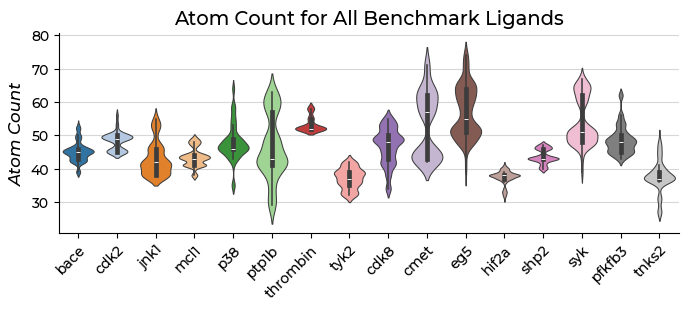

In [14]:
palette = "tab20"
fig, ax = plt.subplots(figsize=(8, 2.6))

violinplot = sns.violinplot(
    results,
    x="target",
    y="n_atoms",
    ax=ax,
    palette=palette,
    # edgecolor="black",
    linewidth=0.75,
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor",
    fontsize=9,
)

ax.set_title(
    "Atom Count for All Benchmark Ligands",
)
ax.set_ylabel("Atom Count")
ax.set_xlabel("")
ax.grid(axis="y", alpha=0.5)

ax.set_axisbelow(True)
plt.subplots_adjust(hspace=0.4)
sns.despine(ax=ax, top=True, right=True)
set_font_properties(ax)
fig.savefig("../figures/ligand_sizes.svg", bbox_inches="tight")
fig.savefig("../figures/ligand_sizes.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()